### Bulygin Ivan HW4. 

Code for __Part 1__ is partially based on code provided in test_funcitions_quad.ipynb

Code below is provided to find an optimum of the following function using first-order methods.

$$f(x) = \frac{1}{2}(x, Q x) + (b, x)$$
$$\nabla f(x) = Qx + b$$

$$x^* = - Q^{-1} b$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from scipy.optimize import minimize_scalar

In [4]:
# initialize random generator to get reproduceable results
np.random.seed(42)

# generate matrix Q and vector b
n = 5
m = 2
A = np.random.rand(n, m)
b = 4 * np.random.rand(m)
Q = A.T.dot(A)

# important parameters of the problem
eigs = np.linalg.eigvals(Q)
L = max(eigs)
mu = min(eigs)

print('b = {}'.format(b))
print('Q = \n{}'.format(Q))
print('mu = {}, L = {}'.format(mu, L))

# minimum
x_star = -np.linalg.inv(Q).dot(b)
# some initial point
x_0 = x_star - [8, -1.5]

b = [0.08233798 3.87963941]
Q = 
[[1.06515021 1.29457678]
 [1.29457678 2.53821185]]
mu = 0.31224936468495423, L = 3.291112700725653


# Part 1

let's firstly derive optimal value of the $\gamma$ which will be used in `optimal_gamma`:

$$ f(x + \gamma p)  = \frac{1}{2}((x + \gamma p), Q (x + \gamma p)) + (b, (x + \gamma p))$$


Let's denote $x + \gamma p$ as $\xi$:

$$\frac{\partial}{\partial \gamma} f(x + \gamma p) = 
\frac{\partial f(x)}{\partial \xi}  \frac{\partial \xi}{\partial \gamma} = 
(((x + \gamma p)^T + Q) + b^T)p = 0
$$

From here we get:

$$ \gamma^* = - \frac{(b^T + x^TQ)p}{p^TQp} = - \frac{\nabla f^T p}{p^TQp} $$

In [5]:
# function and its gradient (calculated manually)
def quad(Q, b, x):
    return ( 0.5 * Q.dot(x) + b).dot(x)

def quad_grad(Q, b, x):
    return Q.dot(x) + b

# auxilary function for contour lines
def quad_2d_XY(Q, b, X, Y):
    Z = np.zeros(shape = X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = quad(Q, b, (X[i,j], Y[i,j]))
    return Z

def optimal_gamma(x, prev_step, Q, p, eps = 1e-10):
    p_ = p(x) # anti-gradient
    step = np.dot(p_, p_) / (np.dot(np.dot(Q,p_), p_) + eps)
    return step if step <= prev_step else prev_step

def golden_ratio(f, bounds, eps = 1e-10):
    a,b = bounds
    F = (1. + np.square(5))/2.

    while True:

        x1 = a + (b - a)/F
        x2 = b - (b - a)/F
        f_1 = f(x1)
        f_2 = f(x2)
        diff = np.abs(x2 - x1).sum()
        if diff < eps:
            return x1
        
        if f_2 > f_1:
            b = x2
        else:
            a = x1
        
def golden_ratio_gamma(x, prev_step, f, p, alpha_bounds = [0., 10.]):
    
    functional = lambda alpha: f(x + alpha*p(x))
    
    return golden_ratio(functional, alpha_bounds)


def armijo_condifion(x, f, f_grad, p, alpha):
    
    eps = 1e-10
    sygma1 = 0.1
    sygma2 = 1. - eps
    
    c = f(x + alpha*p(x)) <= f(x) + sygma1*alpha*np.dot(f_grad(x),p(x))

    return c

def armijo_gamma(x, prev_step, f, f_grad, p):
    
    alpha = 1.
    
    while not armijo_condifion(x, f, f_grad, p, alpha):
        
        alpha = alpha/2.
    
    return alpha

def coordinate_step(x, gradient, method = None):
    
    step = np.zeros_like(gradient, dtype=np.float)
    
    multi_index = []
    for dim in range(x.ndim):
        index = np.random.choice(range(x.shape[dim]))
        multi_index += [index]
    
    step[tuple(multi_index)] = 1.
    
    return np.multiply(step, gradient)/np.linalg.norm(gradient)


def fibonacci(k):
    if k <= 1:
        return 1
    
    x = fibonacci(k-1) + fibonacci(k-2)
    return x


def fibonacci_search(f, bounds, max_iter = 1000, eps = 1e-10, N = 5):
    
    alpha_1, alpha_2 = bounds
      
    F = list(map(fibonacci, range(N)) )

    while True:
        x1 = alpha_1 + F[N-3]*(alpha_2 - alpha_1)/F[N-1] # lesser
        x2 = alpha_1 + F[N-2]*(alpha_2 - alpha_1)/F[N-1] # bigger

        f_1 = f(x1)
        f_2 = f(x2)
        diff = np.abs(x2 - x1).sum()
        alpha = (x1 + x2)/2.

        if diff < eps or alpha <= 0.01:
            return alpha

        if f_2 > f_1:
            alpha_2 = x2
        else:
            alpha_1 = x1
    
def fibonacci_gamma(x, prev_step, f, p):
    
    functional = lambda alpha: f(x + alpha*p(x))
    
    return fibonacci_search(f = functional, bounds = [0., prev_step])

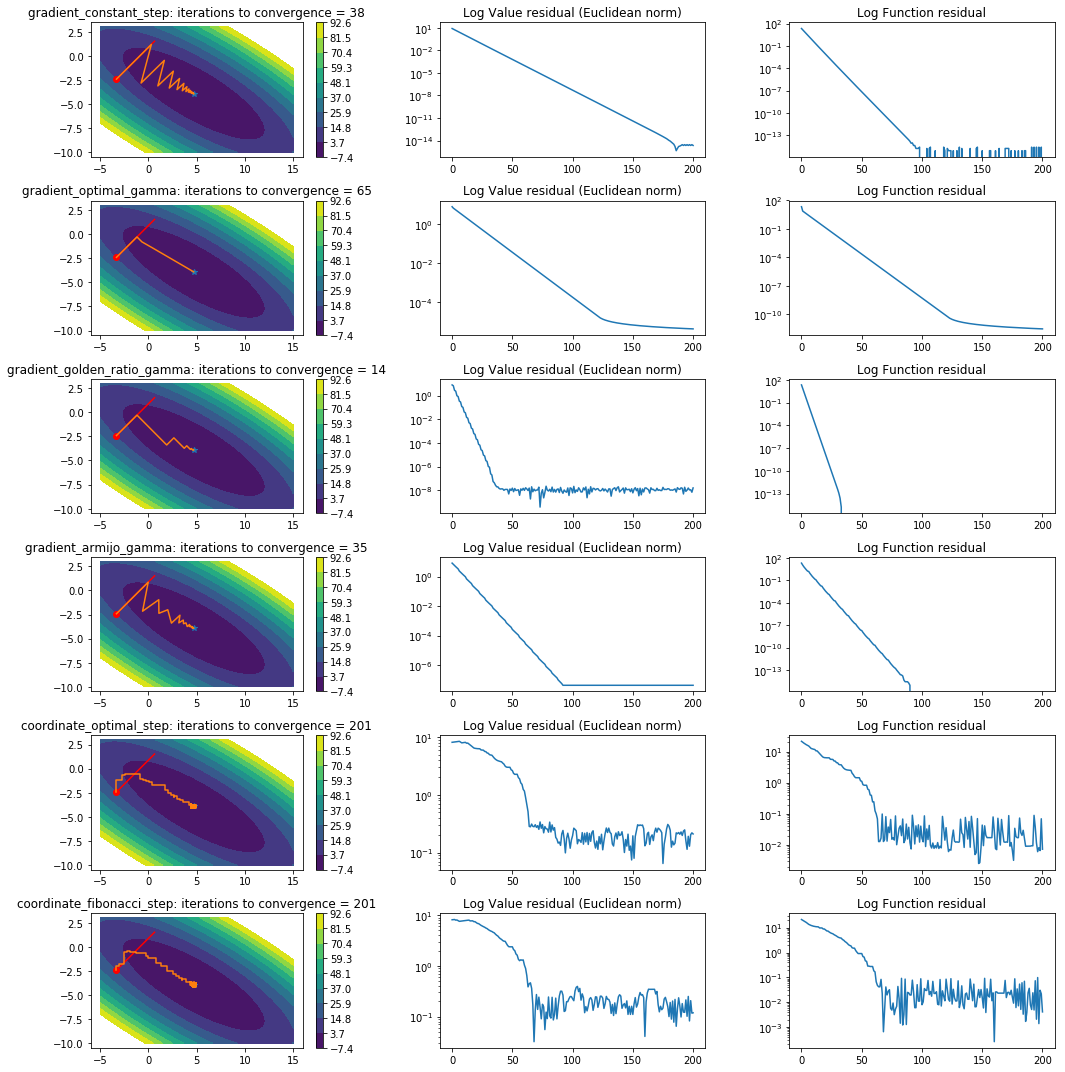

In [6]:
# prepare image
fig, axes = plt.subplots(6, 3, figsize=(15, 15))
# plot contours
X, Y = np.meshgrid(np.linspace(-5, 15, 400), np.linspace(-10, 3, 100))
Z_quad = quad_2d_XY(Q, b, X, Y)
f_star = quad(Q, b, x_star)

# some step-size
gamma = 0.6
# levels for contour lines
levels = np.linspace(f_star, f_star + 100, 10)

# on both sub-plots plot:
for i in range(axes.shape[0]):
    # having equal axes is important to see if lines orthogonal or not
    axes[i][0].axis('equal')
    # minimum
    axes[i][0].plot(x_star[0], x_star[1], '*')
    # initial point
    axes[i][0].plot(x_0[0], x_0[1], 'or')
    # a segment in anti-gradient direction
    axes[i][0].plot((x_0[0], (x_0 - gamma*quad_grad(Q, b, x_0))[0]), 
                 (x_0[1], (x_0 - gamma*quad_grad(Q, b, x_0))[1]), 'r')
    # plot contour lines
    cs = axes[i][0].contourf(X, Y, Z_quad, levels)
    plt.colorbar(cs, ax = axes[i][0])

# -------------------------------------------------------------------    
# A solver function.
def solver(x0,
           f,
           max_iter = 200,
           stepsize_func = None,
           step_func = None,
           gamma_0 = 0.55):
    '''
    Solver example. 
    Input:
        x0 - initial point
        f - function with signature f(x)
        f_grad - function with signature f_grad(x)
        solving_type -  
    Output:
        dictionary with keys:
            'x_k': list of intermediate points
            'f_k': list of intermediate function values
    '''
    x = x0.copy()
    gamma = gamma_0
    x_array = [x]
    f_array = [ f(x) ]
    gamma_array = [ gamma ]
    
    # stopping rule
    for k in range(max_iter):
        
        # we use gamma_k chose optimally
        gamma = stepsize_func(x, gamma)
        
        x = x + gamma * step_func(x)
        
        x_array += [ x ]
        f_array += [ f(x) ]
        gamma_array += [ gamma ]
    
    return {'x_k' : x_array, 'f_k' : f_array, 'gamma_k':gamma_array}

# if function residual less than eps we suppose that algorithm found the minima
eps = 1e-5
f_x = lambda x : quad(Q, b, x)
f_antigrad_x = lambda x : -quad_grad(Q, b, x)
f_grad_x = lambda x : quad_grad(Q, b, x)

solver_setups = {'gradient_constant_step': { 'step_func': f_antigrad_x,
                                            'stepsize_func': lambda x,y: 0.55,
                                            'stepsize_func_params':{}},
                 
                  'gradient_optimal_gamma':{'step_func': f_antigrad_x,
                                          'stepsize_func': optimal_gamma,
                                          'stepsize_func_params': {'Q':Q,
                                                                   'p':f_antigrad_x}},

                  'gradient_golden_ratio_gamma':{'step_func': f_antigrad_x,
                                                'stepsize_func': golden_ratio_gamma,
                                                'stepsize_func_params' : {'f': f_x,
                                                                          'p': f_antigrad_x}},
                 
                  'gradient_armijo_gamma':{'step_func': f_antigrad_x,
                                          'stepsize_func': armijo_gamma,
                                          'stepsize_func_params': { 'f': f_x,
                                                                    'f_grad': f_grad_x,
                                                                    'p': f_antigrad_x}},
                
                 'coordinate_optimal_step':{'step_func': lambda x: coordinate_step(x, f_antigrad_x(x)),
                                              'stepsize_func': optimal_gamma,
                                              'stepsize_func_params': {'Q':Q,
                                                                       'p': lambda x: f_antigrad_x(x)}},
                 
                 'coordinate_fibonacci_step':{'step_func': lambda x: coordinate_step(x, f_antigrad_x(x)),
                                              'stepsize_func': fibonacci_gamma,
                                              'stepsize_func_params': {'f':f_x,
                                                                       'p': lambda x: f_antigrad_x(x)}},                
                }

for k, setup in enumerate(solver_setups.keys()):
    
    # run solver. functions are generated in-place as lambda-functions
    step_func = solver_setups[setup]['step_func']
    stepsize_func = solver_setups[setup]['stepsize_func']
    stepsize_func_params = solver_setups[setup]['stepsize_func_params']
    
    alg_data = solver(x_0,
                      f = f_x,
                      step_func = step_func, 
                      stepsize_func = lambda x, prev_step: stepsize_func(x, prev_step, **stepsize_func_params))

    # convert list of vectors to 2D-array of dimension N x 2
    x_data = np.array(alg_data['x_k'])
    
    
    f_data = np.array(alg_data['f_k'])
    gamma_data = np.array(alg_data['gamma_k'])
    
    axes[k][0].plot(x_data[:, 0], x_data[:, 1])
    axes[k][0].set_title('{0}: iterations to convergence = {1}'.format(setup, sum( np.abs(f_data - f_star) > eps )))
    
    # residual f(x_k) - f* (with broadcasting)
    f_k_residual = f_data - f_star
    N = len(f_k_residual)
    x_k_residual = x_data - np.kron(np.ones( (N, 1) ), x_star)
    
    
    axes[k][2].semilogy(np.arange(N),f_k_residual)
    axes[k][2].set_title('Log Function residual')
    axes[k][1].semilogy(np.arange(N), np.linalg.norm(x_k_residual, axis=1))
    axes[k][1].set_title('Log Value residual (Euclidean norm)')

plt.tight_layout()
plt.show()

# 2.1 Defining LP problem


Let's formulate the minimum fuel optimal control problem as LP:  

We need rewrite it to something that looks like this __(1)__:  

$$
\begin{equation}
\text{min} \:\: c^Tu  + b \\
Gu \leq h \\ 
Du = d
\end{equation}
$$

We are asked to minimize: 
$$ F = \sum_{t=0}^{N-1} f(u(t))  $$  
$$ f(u) = 
\begin{cases}
|u|, \text{if} \:\:  |u| \leq 1 \\
2|u| - 1, \text{if} \:\:  |u| > 1 
\end{cases} 
$$

The problem is that $f$ isn't linear. But we can majorize each $f(u(t_i))$ by $\psi_i$, then:

$$ F = \sum_{i=0}^{N-1} f(u(t)) \leq \sum_{i=0}^{N-1} \psi_i  $$

So we've got a linear functional.
Since $F(u_i) = max( |u_i|, 2|u_i| - 1 )$ we can choose $\psi_i$ such that:
$$
\begin{equation}
\begin{cases}
\psi_i \geq   2|u_i| - 1\\
\psi_i \geq |u_i| 
\end{cases} 
\end{equation}
$$
But these restrictions aren't linear. Let's expand modulus in these inequations:

$$ 
\begin{cases}
|u_i| \leq   \frac{\psi_i + 1}{2}\\
 |u_i| \leq  \psi_i
\end{cases} 
\:\:\: \text{or}\:\:\: 
\begin{cases}
-\frac{\psi_i + 1}{2} \leq u_i \leq   \frac{\psi_i + 1}{2}\\
 -\psi_i \leq u_i \leq  \psi_i
\end{cases} 
$$

So we've got linear restrictions.  There is only one thing lelf: we need to consider the restriction $ x(N) = x_{des} $  
Let's write the $x$'th sequence given by this equation:

$$x(t) = Ax(t-1) + bu(t-1)$$

$$
\begin{equation}
x(0) = 0 \\
x(1) = Ax(0) + bu(0) = bu(0) \\
x(2) = Ax(1) + bu(1) = Abu(0) + bu(1) \\
... \\
x(N)  = Ax(N-1) + bu(N-1)
\end{equation}
$$

Using expression for $x(2)$ one's can derive $x(N) = \sum_{i=0}^{N-1} A^i bu(N - i - 1) = Du = x_{des}$, where $D = [A^{N-1}b, ..., Ab, b]$, since we define $A^0 = E$.  

Therefore we've got the taks which is similar to __(1)__:



$$
\begin{equation}
\text{min} \:\: e^T\psi \\
u \leq \psi \\
u \geq -\psi \\ 
u \geq -\frac12 E \psi -\frac12 e \\ 
u \leq \frac12 E \psi + \frac12 e \\ 
Du = x_{des}
\end{equation}
$$

Where $e = [1,...,1]^T, \psi = [\psi_1,..., \psi_n]^T, u = [u_1,..., u_n]^T$.


# 2.2 Solving LP problem

In [0]:
from cvxpy import Minimize, Problem, Variable

The minimal amount of total fuel consumed is: 17.323567855650253


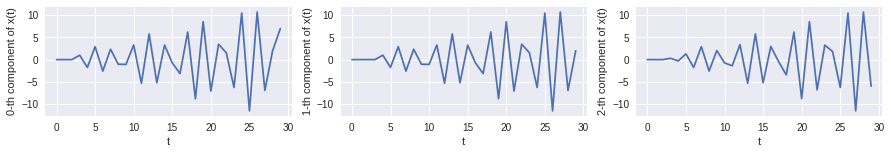

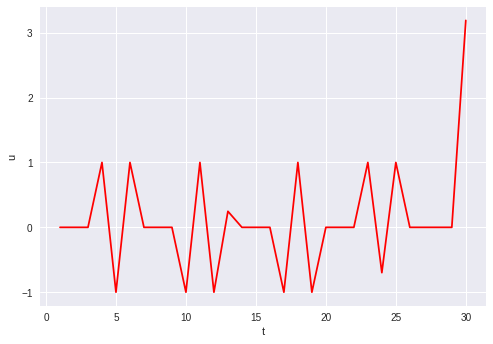

In [228]:
N = 30
A = np.array([[-1.,0.4,0.8],
              [1., 0. , 0.],
              [0., 1.,  0.]])

b = np.array([1., 0., 0.3])
x_des = np.array([7., 2., -6.])

def LP_fuel_control_solver(x_des, A, b, N = 30):

    D = np.apply_along_axis(lambda x: np.dot(np.linalg.matrix_power(A,int(x)), b),
                           0,
                           [np.arange(N, dtype = np.int)[::-1]])

    e = np.ones(30)
    E = np.eye(30)
    psi = Variable(shape = (N,))
    u= Variable(shape = (N,))
    constraints = [ u <= 0.5*psi + 0.5*e,
                   u >= -0.5*psi - 0.5*e,
                   u <= psi,
                   u >= -psi,
                   D@u == x_des]
    obj = Minimize(e@psi)
    prob = Problem(obj, constraints)
    sol = prob.solve()

    return obj, sol, u

_, solution, u = LP_fuel_control_solver(x_des, A, b, N = 30)

fig, axes = plt.subplots(nrows=1, ncols = 3, figsize = (15,2))

x_s = [np.zeros_like(x_des)]

for i in range(N):
    x_s += [A @ x_s[i] + u.value[i]*b]

x_s = np.array(x_s[1:])    
for i,ax in enumerate(axes.flatten()):
  
    ax.plot(range(N), x_s[:,i])
    ax.set_ylabel('{}-th component of x(t)'.format(i))
    ax.set_xlabel('t')


print ('The minimal amount of total fuel consumed is:', solution)
plt.figure()
plt.plot(range(1,N+1), u.value, 'r')
plt.xlabel('t')
plt.ylabel('u')
plt.show()

# 2.3 Sensetivity issue

Let's consider an original Lagrangian of the defined LP:

$$ \mathcal{L} =  
e^T \psi +
\lambda^T(u - \psi) - 
\hat{\lambda}^T(u + \psi)+
\mu^T(\frac12 E\psi - \frac12e - u) -
\hat{\mu}^T(\frac12 E\psi + \frac12e - u) + 
\alpha^T(Du - x_{des})
$$

And Largrange with permuted $x_{des}$:  

$$ \mathcal{L}_{permuted} =  
e^T \psi +
\lambda^T(u - \psi) - 
\hat{\lambda}^T(u + \psi)+
\mu^T(\frac12 E\psi - \frac12e - u) -
\hat{\mu}^T(\frac12 E\psi + \frac12e - u) + 
\alpha^T(Du - (x_{des} + \varepsilon)) = 
\mathcal{L} + \alpha^T \varepsilon
$$

Permutations in $x_{des}$ will affect the Lagrange form which will lead to changes in $u^*$

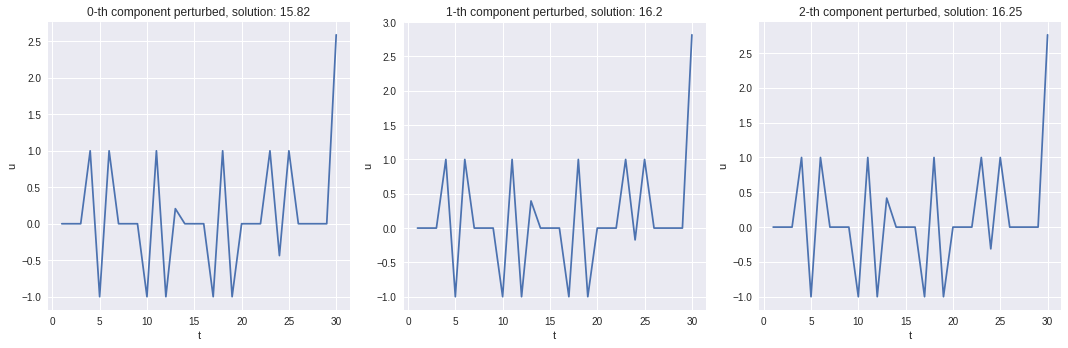

In [229]:
n_trials = x.shape[0]
fig, axes = plt.subplots(nrows = 1, ncols = n_trials, figsize = (15, 5))

for i, (x_des_pert, ax) in enumerate(zip(perturbations, axes.flatten())):
  
    x_pert = x_des

    x_pert[i] += np.random.randn(1)
    _, solution, u_pert = LP_fuel_control_solver(x_pert, A, b, N = 30)
    
    ax.plot(range(1,N+1), u_pert.value)
    ax.set_xlabel('t')
    ax.set_ylabel('u')
    ax.set_title('{0}-th component perturbed, solution: {1}'.format(i,round(solution,2)))
plt.tight_layout()
plt.show()

As we can see the solution $u$ is slightly depend on the $x_{des}$